# Forecasting 101

El propósito de esta notebook es mostrar ejemplos prácticos del proceso de Forecasting en sus cuatro etapas

* Entendimiento de la serie
* Armado de benchmarks
* Experimentación y predicción
* Medición

Usaremos datos reales de la estación Alberdi de peajes de la Ciudad de Buenos Aires para ilustrar cada etapa del proceso

## Inicialización

In [ ]:
## instalamos las librerias necesarias para poder analizar el notebook

!pip install pystan~=2.14 statsmodels scipy lightgbm --quiet
!pip install prophet --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 33.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user


In [ ]:
!pip install statsmodels scipy lightgbm --quiet

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#from prophet import Prophet
from lightgbm import LGBMRegressor
from scipy.stats import pearsonr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_csv_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSvqrklwtgV3TR0gT75neZ_IiKTrRy3rn0tS6T377VZUWKB8PlizjPrRIDiBddUJ4GznG_vADHev6U2/pub?gid=2097768792&single=true&output=csv'

df = pd.read_csv(train_csv_url)
df['fecha'] = pd.to_datetime(df['fecha'], format = '%Y-%m-%d')
df.head()

,estacion,fecha,cantidad_pasos,Year-Month,Weekday,Weekday_Name,lag_1,diff_1,avg_by_weekday,cantidad_pasos_deseas,...,month-May,month-November,month-October,month-September,Weekday_Name-Monday,Weekday_Name-Saturday,Weekday_Name-Sunday,Weekday_Name-Thursday,Weekday_Name-Tuesday,Weekday_Name-Wednesday
0,alberdi,2016-01-01,5446.0,2016-01,4,Friday,NaN,NaN,10208.830600,0.533460,...,0,0,0,0,0,0,0,0,0,0
1,alberdi,2016-01-02,6927.0,2016-01,5,Saturday,5446.0,1481.0,8592.125683,0.806203,...,0,0,0,0,0,1,0,0,0,0
2,alberdi,2016-01-03,6630.0,2016-01,6,Sunday,6927.0,-297.0,6611.759563,1.002759,...,0,0,0,0,0,0,1,0,0,0
3,alberdi,2016-01-04,9835.0,2016-01,0,Monday,6630.0,3205.0,9240.131868,1.064379,...,0,0,0,0,1,0,0,0,0,0
4,alberdi,2016-01-05,9091.0,2016-01,1,Tuesday,9835.0,-744.0,9777.725275,0.929766,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Armamos una funcion inicial para plotear resultados
def plot_results(df: pd.DataFrame,
                 start_date: str = '2019-04-01',
                 end_date: str = '2019-07-31',
                 forecast_col: list = None,
                 model_name: str = None) -> None:
    # Filtramos por fecha
    df_filt = df[(df['fecha'] >= start_date) & (df['fecha'] <= end_date)]

    # Creamos el grafico
    fig, ax = plt.subplots(figsize=(18, 6))
    ax.plot(df_filt['fecha'], df_filt['cantidad_pasos'], label='Historia')

    # Si tenemos un forecast, lo graficamos
    if forecast_col:
        for col in forecast_col:
            ax.plot(df_filt['fecha'], df_filt[col], label=f'Forecast - {col}')

    if model_name:
        ax.set_title(f'Historia y forecast - modelo {model_name}')
    else:
        ax.set_title(f'Serie histórica')

    ax.legend()
    ax.tick_params(labelrotation=90)
    plt.show();

## Armado de benchmarks

### Naïve Last Value

In [ ]:
df['Naive Last Value Forecast'] = df['cantidad_pasos'].shift(1)
df['Naive Last Value Forecast'] = df['Naive Last Value Forecast'].fillna(method='ffill')

df[['cantidad_pasos','Naive Last Value Forecast']].head()

,cantidad_pasos,Naive Last Value Forecast
0,5446.0,NaN
1,6927.0,5446.0
2,6630.0,6927.0
3,9835.0,6630.0
4,9091.0,9835.0


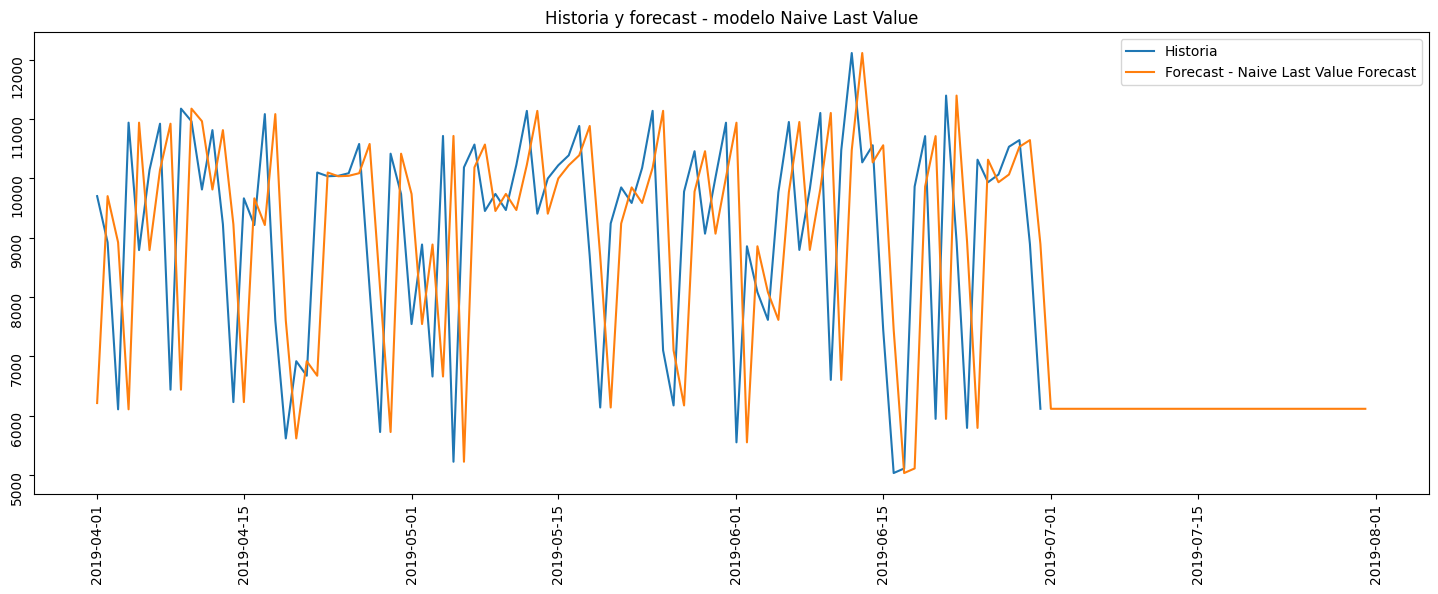

In [ ]:
plot_results(df, start_date='2019-04-01', end_date='2019-07-31', forecast_col=['Naive Last Value Forecast'], model_name='Naive Last Value')

### Naïve Last Cycle

In [ ]:
df['Naive Last Cycle Forecast'] = df['cantidad_pasos'].shift(364)
df['Naive Last Cycle Forecast'] = df['Naive Last Cycle Forecast'].fillna(method='ffill')

df[['fecha', 'cantidad_pasos','Naive Last Cycle Forecast']].loc[df.fecha > '2016-12-20'].head(10)

,fecha,cantidad_pasos,Naive Last Cycle Forecast
355,2016-12-21,12056.0,NaN
356,2016-12-22,11850.0,NaN
357,2016-12-23,11716.0,NaN
358,2016-12-24,7456.0,NaN
359,2016-12-25,7239.0,NaN
360,2016-12-26,9561.0,NaN
361,2016-12-27,10643.0,NaN
362,2016-12-28,10891.0,NaN
363,2016-12-29,11364.0,NaN
364,2016-12-30,10041.0,5446.0


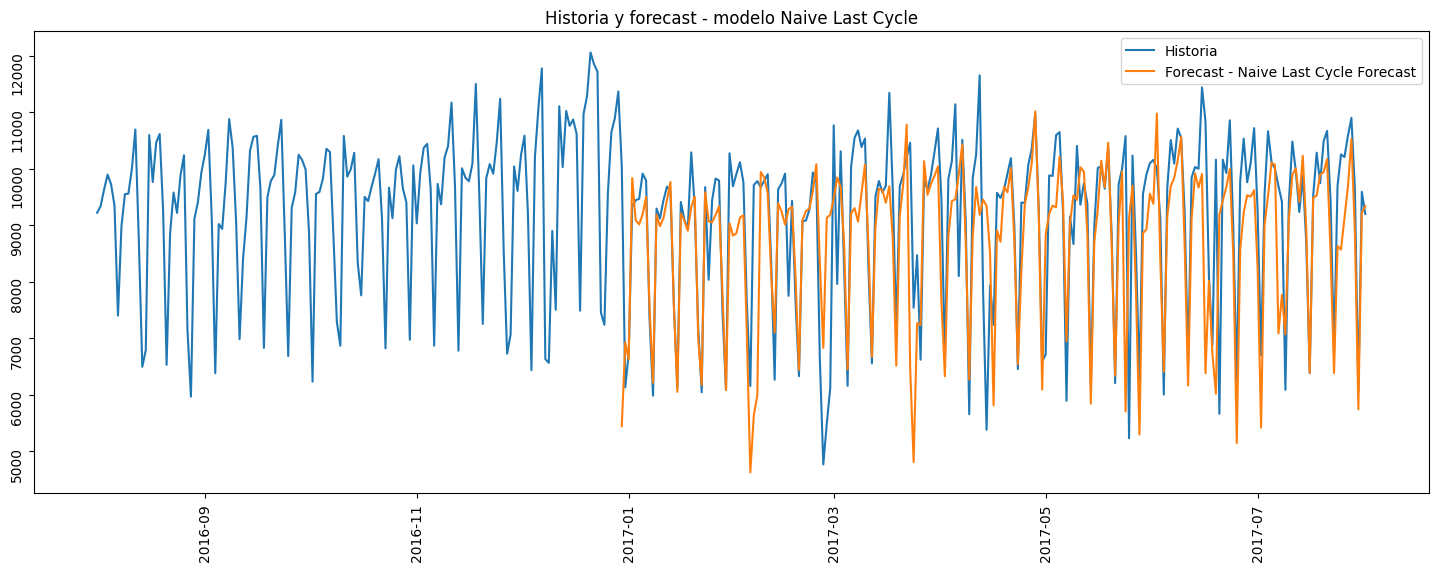

In [ ]:
plot_results(df, start_date='2016-08-01', end_date='2017-08-01', forecast_col=['Naive Last Cycle Forecast'], model_name='Naive Last Cycle')

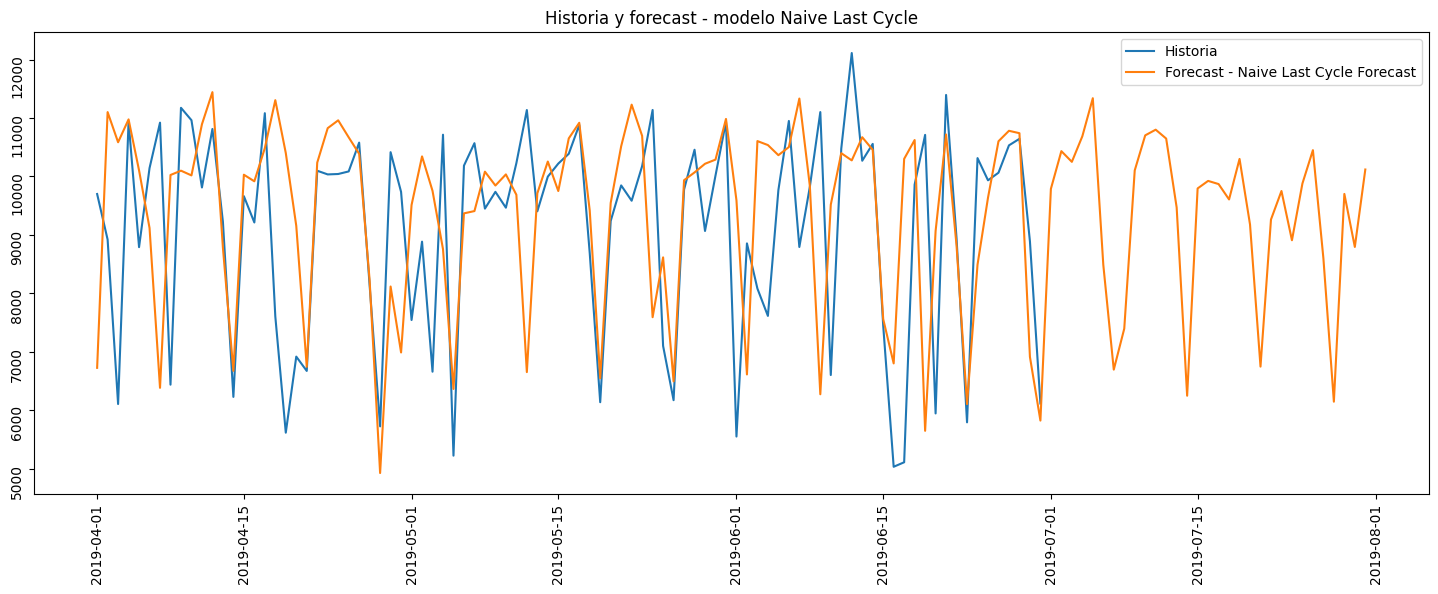

In [ ]:
plot_results(df, start_date='2019-04-01', end_date='2019-07-31', forecast_col=['Naive Last Cycle Forecast'], model_name='Naive Last Cycle')

### Medias Móviles

In [ ]:
for window in [3, 7, 365]:
    df[f'AVG_{window}'] = df['cantidad_pasos'].transform(
        lambda x: x.rolling(window, 1).mean())
    # Para evitar usar el mismo valor para el promedio, lo lageamos
    df[f'AVG_{window}'] = df[f'AVG_{window}'].shift(1).fillna(method='bfill').fillna(method='ffill')


df[['fecha', 'cantidad_pasos','AVG_3', 'AVG_7', 'AVG_365']].head()

,fecha,cantidad_pasos,AVG_3,AVG_7,AVG_365
0,2016-01-01,5446.0,5446.000000,5446.000000,5446.000000
1,2016-01-02,6927.0,5446.000000,5446.000000,5446.000000
2,2016-01-03,6630.0,6186.500000,6186.500000,6186.500000
3,2016-01-04,9835.0,6334.333333,6334.333333,6334.333333
4,2016-01-05,9091.0,7797.333333,7209.500000,7209.500000


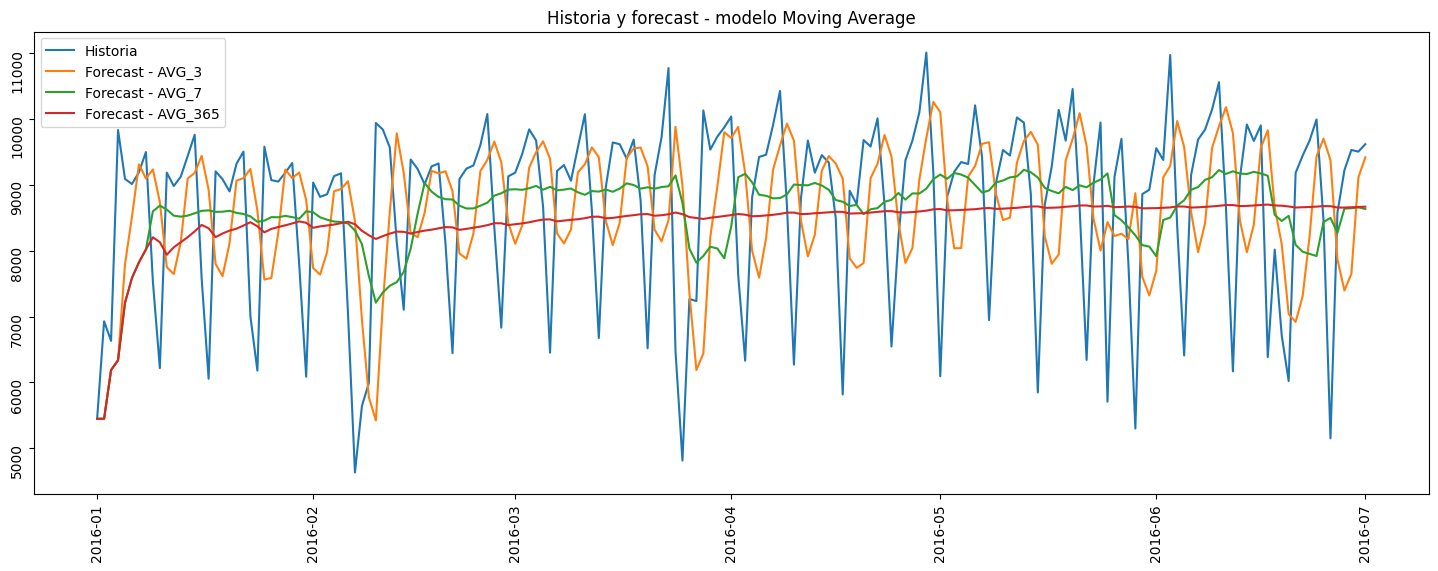

In [ ]:
plot_results(df, start_date='2016-01-01', end_date='2016-07-01', forecast_col=['AVG_3', 'AVG_7', 'AVG_365'], model_name='Moving Average')

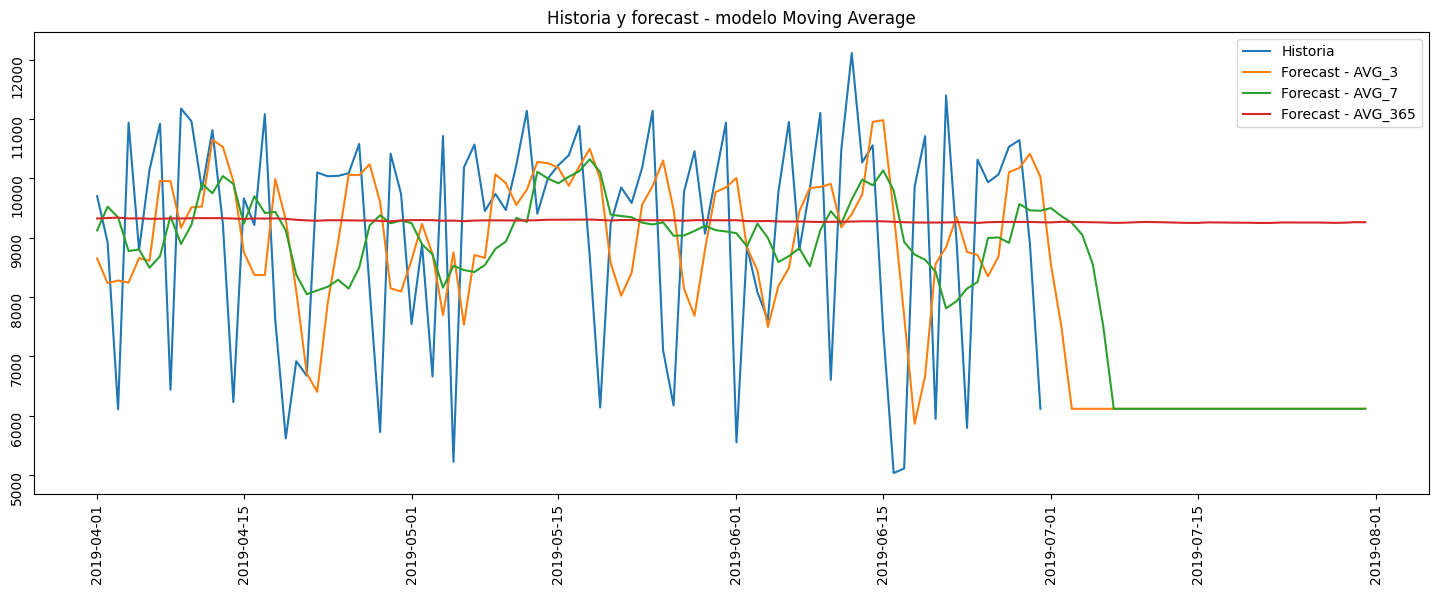

In [ ]:
plot_results(df, start_date='2019-04-01', end_date='2019-07-31', forecast_col=['AVG_3', 'AVG_7', 'AVG_365'], model_name='Moving Average')

### Suavizado Exponencial Simple

In [ ]:
df_no_nan = df[df['fecha'] < '2019-07-01']
df_nan = df[df['fecha'] >= '2019-07-01']

In [ ]:
for alpha in [0.2, 0.5, 0.8]:
    # Fiteo el modelo
    model = SimpleExpSmoothing(df_no_nan['cantidad_pasos']).fit(smoothing_level=alpha, optimized=False)
    # Evaluo el fitting
    fit = list(model.fittedvalues)
    pred = list(model.forecast(len(df_nan)))
    full_pred = fit+pred
    df[f'Expo_{alpha}_pred'] = full_pred


df[['fecha', 'cantidad_pasos', 'Expo_0.2_pred', 'Expo_0.5_pred', 'Expo_0.8_pred']].head()

,fecha,cantidad_pasos,Expo_0.2_pred,Expo_0.5_pred,Expo_0.8_pred
0,2016-01-01,5446.0,5446.000,5446.000,5446.000
1,2016-01-02,6927.0,5446.000,5446.000,5446.000
2,2016-01-03,6630.0,5742.200,6186.500,6630.800
3,2016-01-04,9835.0,5919.760,6408.250,6630.160
4,2016-01-05,9091.0,6702.808,8121.625,9194.032


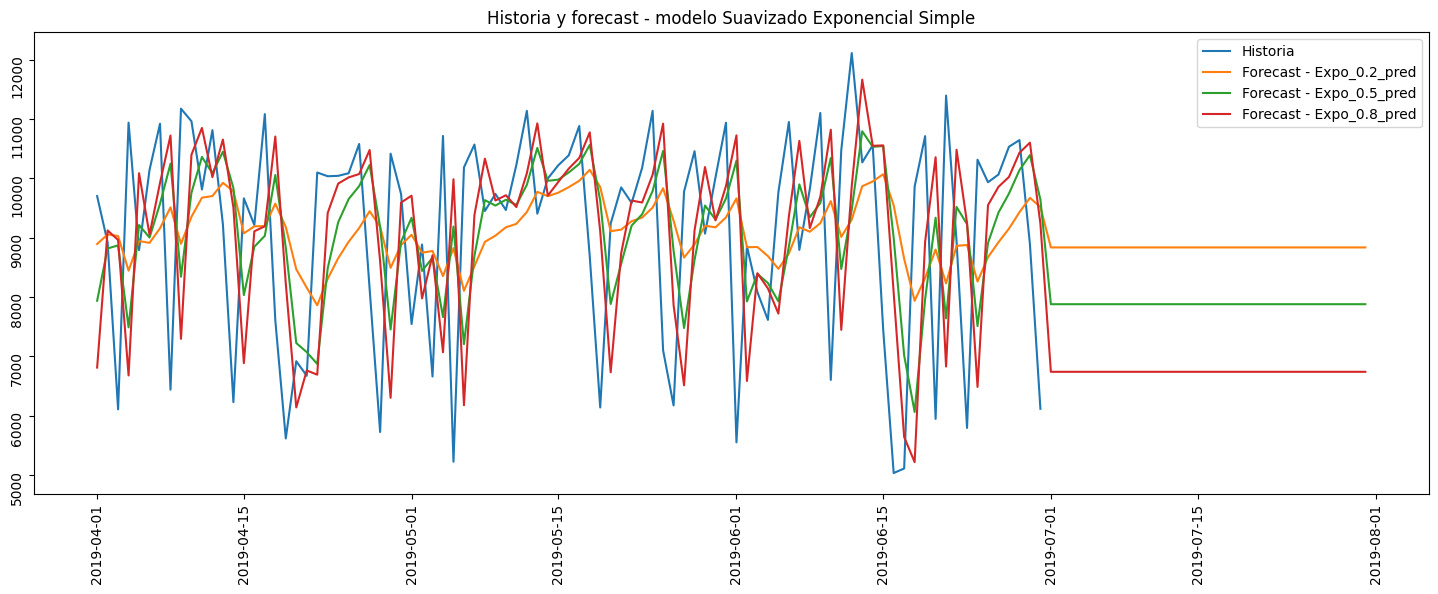

In [ ]:
plot_results(df, start_date='2019-04-01', end_date='2019-07-31', forecast_col=['Expo_0.2_pred', 'Expo_0.5_pred', 'Expo_0.8_pred'], model_name='Suavizado Exponencial Simple')

### Holt

In [ ]:
for beta in [0.2, 0.5, 0.8]:
    # Fiteo el modelo
    model = Holt(df_no_nan['cantidad_pasos']).fit(smoothing_level=0.5, smoothing_trend=beta, optimized=False)
    # Evaluo el fitting
    fit = list(model.fittedvalues)
    pred = list(model.forecast(len(df_nan)))
    pred = [x if x >= 0 else 0 for x in pred]
    full_pred = fit+pred
    df[f'Holt_0.5_{beta}_pred'] = full_pred

df[['fecha', 'cantidad_pasos', 'Holt_0.5_0.2_pred', 'Holt_0.5_0.5_pred', 'Holt_0.5_0.8_pred']].head()

,fecha,cantidad_pasos,Holt_0.5_0.2_pred,Holt_0.5_0.5_pred,Holt_0.5_0.8_pred
0,2016-01-01,5446.0,6927.0000,6927.000000,6927.0000
1,2016-01-02,6927.0,7519.4000,7297.250000,7075.1000
2,2016-01-03,6630.0,8496.8600,8130.312500,7830.4100
3,2016-01-04,9835.0,8650.4040,8023.265625,7579.4010
4,2016-01-05,9091.0,10448.1356,10025.175781,9958.6361


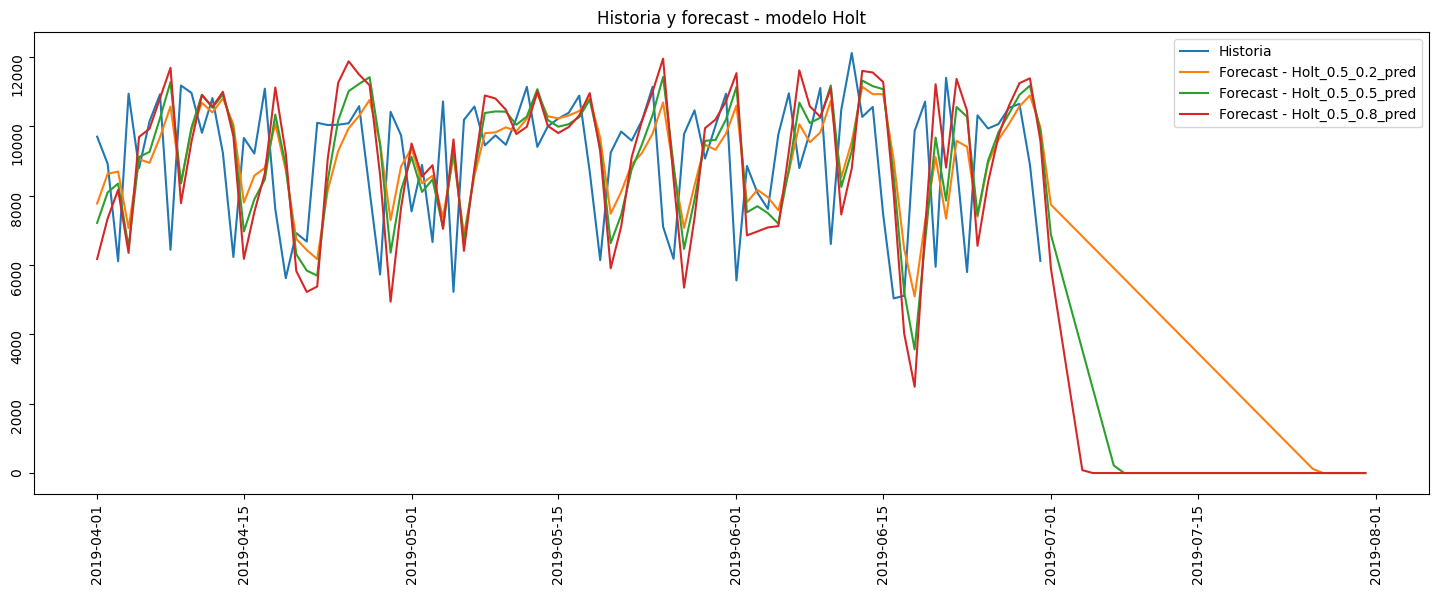

In [ ]:
plot_results(df, start_date='2019-04-01', end_date='2019-07-31', forecast_col=['Holt_0.5_0.2_pred', 'Holt_0.5_0.5_pred', 'Holt_0.5_0.8_pred'], model_name='Holt')

### Holt Winters

In [ ]:
for gamma in [0.2, 0.5, 0.8]:
    # Fiteo el modelo
    model = ExponentialSmoothing(df_no_nan['cantidad_pasos'],
                                 seasonal_periods=364,
                                 trend='add',
                                 seasonal='add').fit(smoothing_level=0.5,
                                                     smoothing_trend=0.1,
                                                     smoothing_seasonal=gamma,
                                                     optimized=False)
    # Evaluo el fitting
    fit = list(model.fittedvalues)
    pred = list(model.forecast(len(df_nan)))
    pred = [x if x >= 0 else 0 for x in pred]
    full_pred = fit+pred
    df[f'Expo_0.5_0.1_{gamma}_pred'] = full_pred

df[['fecha', 'cantidad_pasos', 'Expo_0.5_0.1_0.2_pred', 'Expo_0.5_0.1_0.5_pred', 'Expo_0.5_0.1_0.8_pred']].head()

,fecha,cantidad_pasos,Expo_0.5_0.1_0.2_pred,Expo_0.5_0.1_0.5_pred,Expo_0.5_0.1_0.8_pred
0,2016-01-01,5446.0,9883.169236,9883.169236,9883.169236
1,2016-01-02,6927.0,3937.024337,3937.024337,3937.024337
2,2016-01-03,6630.0,4255.943116,4255.943116,4255.943116
3,2016-01-04,9835.0,7757.149306,7757.149306,7757.149306
4,2016-01-05,9091.0,10921.795347,10921.795347,10921.795347


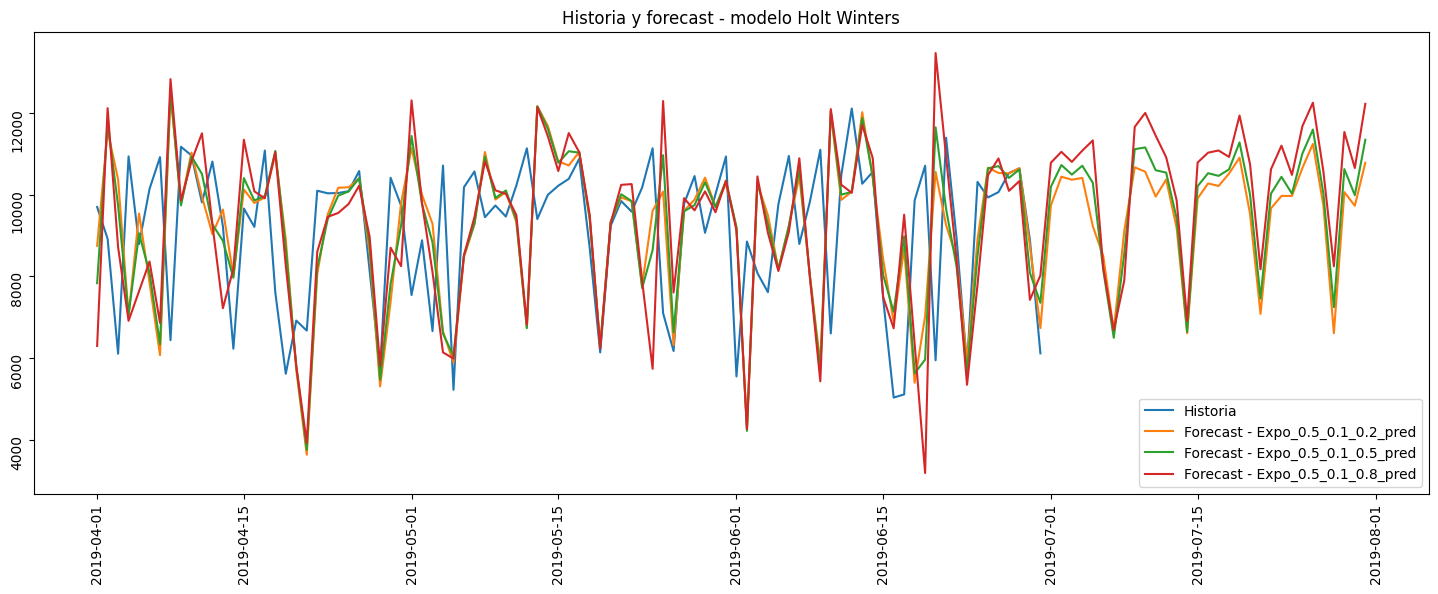

In [ ]:
plot_results(df, start_date='2019-04-01', end_date='2019-07-31', forecast_col=['Expo_0.5_0.1_0.2_pred', 'Expo_0.5_0.1_0.5_pred', 'Expo_0.5_0.1_0.8_pred'], model_name='Holt Winters')

### Suavizado Exponencial Optimizado

In [ ]:
model = ExponentialSmoothing(df_no_nan['cantidad_pasos'],
                             seasonal_periods=364, trend='add', seasonal='add').fit(optimized=True)
# Evaluo el fitting
fit = list(model.fittedvalues)
pred = list(model.forecast(len(df_nan)))
pred = [x if x >= 0 else 0 for x in pred]
full_pred = fit+pred
df[f'Expo_Opti'] = full_pred
df[['fecha', 'cantidad_pasos', 'Expo_Opti']].head()

,fecha,cantidad_pasos,Expo_Opti
0,2016-01-01,5446.0,9883.169236
1,2016-01-02,6927.0,6198.378038
2,2016-01-03,6630.0,5124.058798
3,2016-01-04,9835.0,7452.659975
4,2016-01-05,9091.0,9524.290131


In [ ]:
print('Resultados del modelo óptimo')
print('alpha', model.params['smoothing_level'], 'beta', model.params['smoothing_trend'],
      'gamma', model.params['smoothing_seasonal'])

Resultados del modelo óptimo
alpha 0.040357142857142855 beta 0.0001 gamma 0.0001


model.params

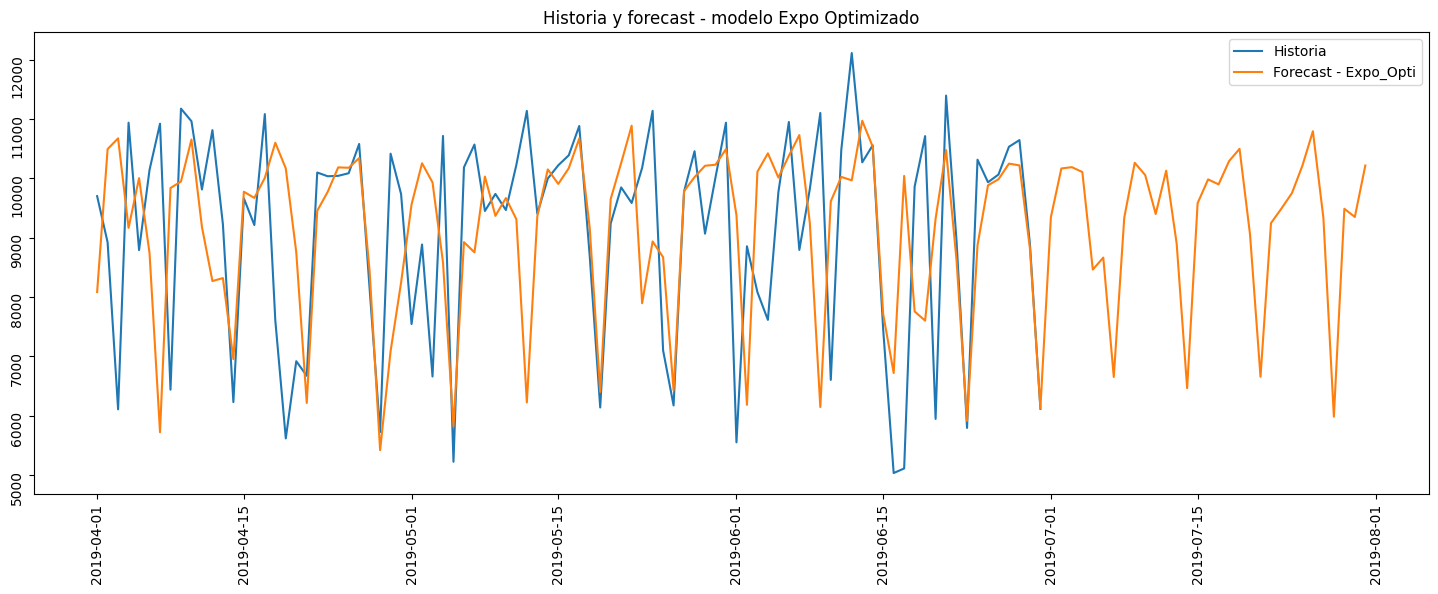

In [ ]:
plot_results(df, start_date='2019-04-01', end_date='2019-07-31', forecast_col=['Expo_Opti'], model_name='Expo Optimizado')

### Modelos Causales


#### OLS

Comenzamos leyendo un archivo con información de clima para poder joinearla con el dataframe original. Además, creamos lags para poder modelar mejor la serie de tiempo

In [ ]:
url_csv_weahter = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vThcQ2iJPnNbZ7-xvdk0wfh7MWN1D5aTQHC0xswDt1P4jr9o9GDwgxduVOtPxAW-4nYM6J91YKvemLi/pub?gid=1855278016&single=true&output=csv'
df_weather = pd.read_csv(url_csv_weahter).rename(columns={'time': 'fecha'})
df_weather['prcp'] = df_weather['prcp'].fillna(0)
df_weather['fecha'] = pd.to_datetime(df_weather['fecha'])
df_weather.head()

,Unnamed: 0,fecha,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,0,2015-01-01,21.5,18.3,28.0,14.0,NaN,223.0,20.8,NaN,NaN,NaN
1,1,2015-01-02,20.0,15.2,25.0,0.0,NaN,219.0,20.3,NaN,NaN,NaN
2,2,2015-01-03,22.8,17.0,29.0,0.0,NaN,NaN,17.4,NaN,NaN,NaN
3,3,2015-01-04,21.0,16.0,29.0,0.0,NaN,128.0,22.6,NaN,NaN,NaN
4,4,2015-01-05,24.4,20.0,31.0,0.0,NaN,31.0,12.9,NaN,NaN,NaN


In [ ]:
df = pd.merge(df, df_weather[['fecha', 'tavg', 'prcp']], how='left', on='fecha')
df.head()

,estacion,fecha,cantidad_pasos,Year-Month,Weekday,Weekday_Name,lag_1,diff_1,avg_by_weekday,cantidad_pasos_deseas,...,Expo_0.8_pred,Holt_0.5_0.2_pred,Holt_0.5_0.5_pred,Holt_0.5_0.8_pred,Expo_0.5_0.1_0.2_pred,Expo_0.5_0.1_0.5_pred,Expo_0.5_0.1_0.8_pred,Expo_Opti,tavg,prcp
0,alberdi,2016-01-01,5446.0,2016-01,4,Friday,NaN,NaN,10208.830600,0.533460,...,5446.000,6927.0000,6927.000000,6927.0000,9883.169236,9883.169236,9883.169236,9883.169236,25.2,0.0
1,alberdi,2016-01-02,6927.0,2016-01,5,Saturday,5446.0,1481.0,8592.125683,0.806203,...,5446.000,7519.4000,7297.250000,7075.1000,3937.024337,3937.024337,3937.024337,6198.378038,26.1,19.1
2,alberdi,2016-01-03,6630.0,2016-01,6,Sunday,6927.0,-297.0,6611.759563,1.002759,...,6630.800,8496.8600,8130.312500,7830.4100,4255.943116,4255.943116,4255.943116,5124.058798,25.7,0.0
3,alberdi,2016-01-04,9835.0,2016-01,0,Monday,6630.0,3205.0,9240.131868,1.064379,...,6630.160,8650.4040,8023.265625,7579.4010,7757.149306,7757.149306,7757.149306,7452.659975,26.4,0.0
4,alberdi,2016-01-05,9091.0,2016-01,1,Tuesday,9835.0,-744.0,9777.725275,0.929766,...,9194.032,10448.1356,10025.175781,9958.6361,10921.795347,10921.795347,10921.795347,9524.290131,26.7,0.5


In [ ]:
for lag in [1, 2, 3, 7]:
    df[f'lag_{lag}'] = df['cantidad_pasos'].shift(lag).fillna(method='bfill')
df.head()

,estacion,fecha,cantidad_pasos,Year-Month,Weekday,Weekday_Name,lag_1,diff_1,avg_by_weekday,cantidad_pasos_deseas,...,Holt_0.5_0.8_pred,Expo_0.5_0.1_0.2_pred,Expo_0.5_0.1_0.5_pred,Expo_0.5_0.1_0.8_pred,Expo_Opti,tavg,prcp,lag_2,lag_3,lag_7
0,alberdi,2016-01-01,5446.0,2016-01,4,Friday,5446.0,NaN,10208.830600,0.533460,...,6927.0000,9883.169236,9883.169236,9883.169236,9883.169236,25.2,0.0,5446.0,5446.0,5446.0
1,alberdi,2016-01-02,6927.0,2016-01,5,Saturday,5446.0,1481.0,8592.125683,0.806203,...,7075.1000,3937.024337,3937.024337,3937.024337,6198.378038,26.1,19.1,5446.0,5446.0,5446.0
2,alberdi,2016-01-03,6630.0,2016-01,6,Sunday,6927.0,-297.0,6611.759563,1.002759,...,7830.4100,4255.943116,4255.943116,4255.943116,5124.058798,25.7,0.0,5446.0,5446.0,5446.0
3,alberdi,2016-01-04,9835.0,2016-01,0,Monday,6630.0,3205.0,9240.131868,1.064379,...,7579.4010,7757.149306,7757.149306,7757.149306,7452.659975,26.4,0.0,6927.0,5446.0,5446.0
4,alberdi,2016-01-05,9091.0,2016-01,1,Tuesday,9835.0,-744.0,9777.725275,0.929766,...,9958.6361,10921.795347,10921.795347,10921.795347,9524.290131,26.7,0.5,6630.0,6927.0,5446.0


In [ ]:
df.columns

Index(['estacion', 'fecha', 'cantidad_pasos', 'Year-Month', 'Weekday',
       'Weekday_Name', 'lag_1', 'diff_1', 'avg_by_weekday',
       'cantidad_pasos_deseas', 'n_obs', 'month', 'month-August',
       'month-December', 'month-February', 'month-January', 'month-July',
       'month-June', 'month-March', 'month-May', 'month-November',
       'month-October', 'month-September', 'Weekday_Name-Monday',
       'Weekday_Name-Saturday', 'Weekday_Name-Sunday', 'Weekday_Name-Thursday',
       'Weekday_Name-Tuesday', 'Weekday_Name-Wednesday',
       'Naive Last Value Forecast', 'Naive Last Cycle Forecast', 'AVG_3',
       'AVG_7', 'AVG_365', 'Expo_0.2_pred', 'Expo_0.5_pred', 'Expo_0.8_pred',
       'Holt_0.5_0.2_pred', 'Holt_0.5_0.5_pred', 'Holt_0.5_0.8_pred',
       'Expo_0.5_0.1_0.2_pred', 'Expo_0.5_0.1_0.5_pred',
       'Expo_0.5_0.1_0.8_pred', 'Expo_Opti', 'tavg', 'prcp', 'lag_2', 'lag_3',
       'lag_7'],
      dtype='object')

In [ ]:
# Seteamos las funciones que utilizaremos para hacer los forecasts
def create_regressors_causal(data_full, data_date, date_column, target_column):
    """
    Function that re-calculates auto regressive variables at every forecast iteration.

    Parameters
    __________
    data_full : pd.DataFrame
        Dataset with dates and values of the target value for the training set and the predicted values of the test set
    data_date : pd.DataFrame
        Dataset with test time series for a particular date
    date_column: str
        String indicating the column that shows the date
    target_column: str
        String indicating the column that is the target
    auto_regressors : list
        List of regressors, depenidng on the time series to add to the model

    Returns
    _______
    data_date : pd.DataFrame
        Dataset with test time series for a particular date with the corrected autoregresors
    """
    # Save column order
    col_order = list(data_date.columns)

    # Concat data_full and data_date to calculate regressors
    data_date_target = data_date[[date_column, target_column]].copy()
    data_date_target[target_column] = np.nan
    data_full_date = pd.concat([data_full, data_date_target], ignore_index=True)

    # Check the lags that exist as regressors
    auto_regressors = []
    lags = [1, 2, 3, 7]
    for lag in lags:
        data_full_date[f'lag_{lag}'] = data_full_date[target_column].shift(lag).fillna(method='bfill')
        auto_regressors.append(f'lag_{lag}')

    # Check the moving averages that are created
    moving_average_window = [3, 7]
    moving_average_window.sort()

    for window in moving_average_window:
        data_full_date[f'AVG_{window}'] = data_full_date[target_column].rolling(window=window, min_periods=1).mean()
        data_full_date[f'AVG_{window}'] = data_full_date[f'AVG_{window}'].shift(1).fillna(method='bfill')
        auto_regressors.append(f'AVG_{window}')

    # Drop auto regressors for data_date
    data_date.drop(columns=auto_regressors, inplace=True)

    # Merge new regressors
    data_full_date = data_full_date[[date_column] + auto_regressors]
    data_date = pd.merge(data_date, data_full_date, how='left', on=[date_column])
    data_date = data_date[col_order]
    return data_date

In [ ]:
def forecast_causal(data_train, data_test, date_column, target_column, regressors, model):
    """
    Does a forecast in a loop fashion for every data point in the dataset. For the autoregressive, we re-calculate them
    at every iteration. For the external regressors, we use the reported values

    Parameters
    __________
    data_train : pd.DataFrame
        Dataset with training time series.
    data_test : pd.DataFrame
        Dataset with test time series.
    date_column: str
        String indicating the column that shows the date
    regressors : list
        List of regressors, depenidng on the time series to add to the model
    model : lightgbm.sklearn.LGBMRegressor
        LightGBM model defined by "params" and trained with the given time series.

    Returns
    _______
    pred : np.ndarray
        Forecast of the test set
    """
    # We create an auxiliary dataframe in which we'll include all the history of the target column and will populate it
    # with forecasts
    data_train = data_train.reset_index(drop=True)
    data_test = data_test.reset_index(drop=True)
    data_full = data_train[[date_column, target_column]]

    pred = []

    # Do a forecast in a loop fashion
    for j in range(len(data_test)):
        date_i = data_test[date_column][j]
        # Filter data for that particular date
        data_date = data_test[data_test[date_column] == date_i]

        # Create new regressors and predict
        data_date = create_regressors_causal(data_full.copy(), data_date, date_column, target_column)
        pred_i = model.predict(data_date[regressors])[0]

        # Append predictions
        pred.append(pred_i)
        pred_date = pd.DataFrame(data={
            date_column: [date_i],
            target_column: [pred_i]
        })
        data_full = pd.concat([data_full, pred_date], ignore_index=True)

    pred = np.array(pred)

    return pred

In [ ]:
df_no_nan = df[df['fecha'] < '2019-07-01']
df_nan = df[df['fecha'] >= '2019-07-01']

In [ ]:
regressors = ['lag_1', 'lag_2', 'lag_3', 'lag_7', 'AVG_3', 'AVG_7', 'tavg', 'prcp', 'month-August',
       'month-December', 'month-February', 'month-January', 'month-July',
       'month-June', 'month-March', 'month-May', 'month-November',
       'month-October', 'month-September', 'Weekday_Name-Monday',
       'Weekday_Name-Saturday', 'Weekday_Name-Sunday', 'Weekday_Name-Thursday',
       'Weekday_Name-Tuesday', 'Weekday_Name-Wednesday']

In [ ]:
df_no_nan.columns


Index(['estacion', 'fecha', 'cantidad_pasos', 'Year-Month', 'Weekday',
       'Weekday_Name', 'lag_1', 'diff_1', 'avg_by_weekday',
       'cantidad_pasos_deseas', 'n_obs', 'month', 'month-August',
       'month-December', 'month-February', 'month-January', 'month-July',
       'month-June', 'month-March', 'month-May', 'month-November',
       'month-October', 'month-September', 'Weekday_Name-Monday',
       'Weekday_Name-Saturday', 'Weekday_Name-Sunday', 'Weekday_Name-Thursday',
       'Weekday_Name-Tuesday', 'Weekday_Name-Wednesday', 'Expo_0.2_pred',
       'Expo_0.5_pred', 'Expo_0.8_pred', 'Holt_0.5_0.2_pred',
       'Holt_0.5_0.5_pred', 'Holt_0.5_0.8_pred', 'Expo_0.5_0.1_0.2_pred',
       'Expo_0.5_0.1_0.5_pred', 'Expo_0.5_0.1_0.8_pred', 'Expo_Opti', 'tavg',
       'prcp', 'lag_2', 'lag_3', 'lag_7', 'AVG_3', 'AVG_7', 'AVG_365'],
      dtype='object')

In [ ]:
Y = df_no_nan['cantidad_pasos']
X = df_no_nan[regressors]
ols = sm.OLS(Y, X)
model = ols.fit()
fit = list(model.predict(df_no_nan[regressors]))
pred = forecast_causal(df_no_nan, df_nan, 'fecha', 'cantidad_pasos', regressors, model)
pred = list(pred)
full_pred = fit+pred
df[f'OLS'] = full_pred
df.head()

,estacion,fecha,cantidad_pasos,Year-Month,Weekday,Weekday_Name,lag_1,diff_1,avg_by_weekday,cantidad_pasos_deseas,...,Expo_Opti,tavg,prcp,lag_2,lag_3,lag_7,AVG_3,AVG_7,AVG_365,OLS
0,alberdi,2016-01-01,5446.0,2016-01,4,Friday,5446.0,NaN,10208.830600,0.533460,...,9883.169236,25.2,0.0,5446.0,5446.0,5446.0,5446.000000,5446.000000,5446.000000,6209.529083
1,alberdi,2016-01-02,6927.0,2016-01,5,Saturday,5446.0,1481.0,8592.125683,0.806203,...,6198.378038,26.1,19.1,5446.0,5446.0,5446.0,5446.000000,5446.000000,5446.000000,4745.513027
2,alberdi,2016-01-03,6630.0,2016-01,6,Sunday,6927.0,-297.0,6611.759563,1.002759,...,5124.058798,25.7,0.0,5446.0,5446.0,5446.0,6186.500000,6186.500000,6186.500000,6630.000000
3,alberdi,2016-01-04,9835.0,2016-01,0,Monday,6630.0,3205.0,9240.131868,1.064379,...,7452.659975,26.4,0.0,6927.0,5446.0,5446.0,6334.333333,6334.333333,6334.333333,7089.260440
4,alberdi,2016-01-05,9091.0,2016-01,1,Tuesday,9835.0,-744.0,9777.725275,0.929766,...,9524.290131,26.7,0.5,6630.0,6927.0,5446.0,7797.333333,7209.500000,7209.500000,8403.022225


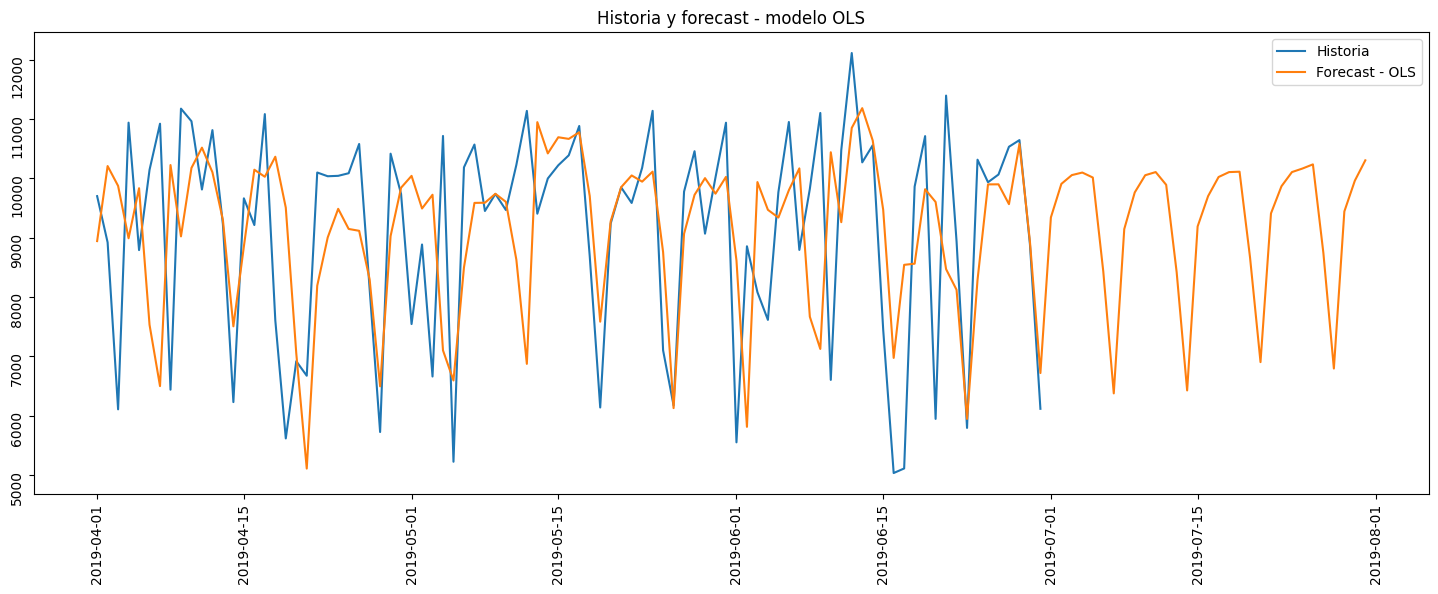

In [ ]:
plot_results(df, start_date='2019-04-01', end_date='2019-07-31', forecast_col=['OLS'], model_name='OLS')

#### LightGBM

In [ ]:
model = LGBMRegressor()
model.fit(df_no_nan[regressors], df_no_nan['cantidad_pasos'])
fit = list(model.predict(df_no_nan[regressors]))
pred = forecast_causal(df_no_nan, df_nan, 'fecha', 'cantidad_pasos', regressors, model)
pred = list(pred)
full_pred = fit+pred
df[f'LightGBM'] = full_pred
df.head()

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1786
[LightGBM] [Info] Number of data points in the train set: 1277, number of used features: 25
[LightGBM] [Info] Start training from score 9223.981989


,estacion,fecha,cantidad_pasos,Year-Month,Weekday,Weekday_Name,lag_1,diff_1,avg_by_weekday,cantidad_pasos_deseas,...,tavg,prcp,lag_2,lag_3,lag_7,AVG_3,AVG_7,AVG_365,OLS,LightGBM
0,alberdi,2016-01-01,5446.0,2016-01,4,Friday,5446.0,NaN,10208.830600,0.533460,...,25.2,0.0,5446.0,5446.0,5446.0,5446.000000,5446.000000,5446.000000,6209.529083,6876.192805
1,alberdi,2016-01-02,6927.0,2016-01,5,Saturday,5446.0,1481.0,8592.125683,0.806203,...,26.1,19.1,5446.0,5446.0,5446.0,5446.000000,5446.000000,5446.000000,4745.513027,6554.402621
2,alberdi,2016-01-03,6630.0,2016-01,6,Sunday,6927.0,-297.0,6611.759563,1.002759,...,25.7,0.0,5446.0,5446.0,5446.0,6186.500000,6186.500000,6186.500000,6630.000000,6670.488511
3,alberdi,2016-01-04,9835.0,2016-01,0,Monday,6630.0,3205.0,9240.131868,1.064379,...,26.4,0.0,6927.0,5446.0,5446.0,6334.333333,6334.333333,6334.333333,7089.260440,9609.213514
4,alberdi,2016-01-05,9091.0,2016-01,1,Tuesday,9835.0,-744.0,9777.725275,0.929766,...,26.7,0.5,6630.0,6927.0,5446.0,7797.333333,7209.500000,7209.500000,8403.022225,9353.630492


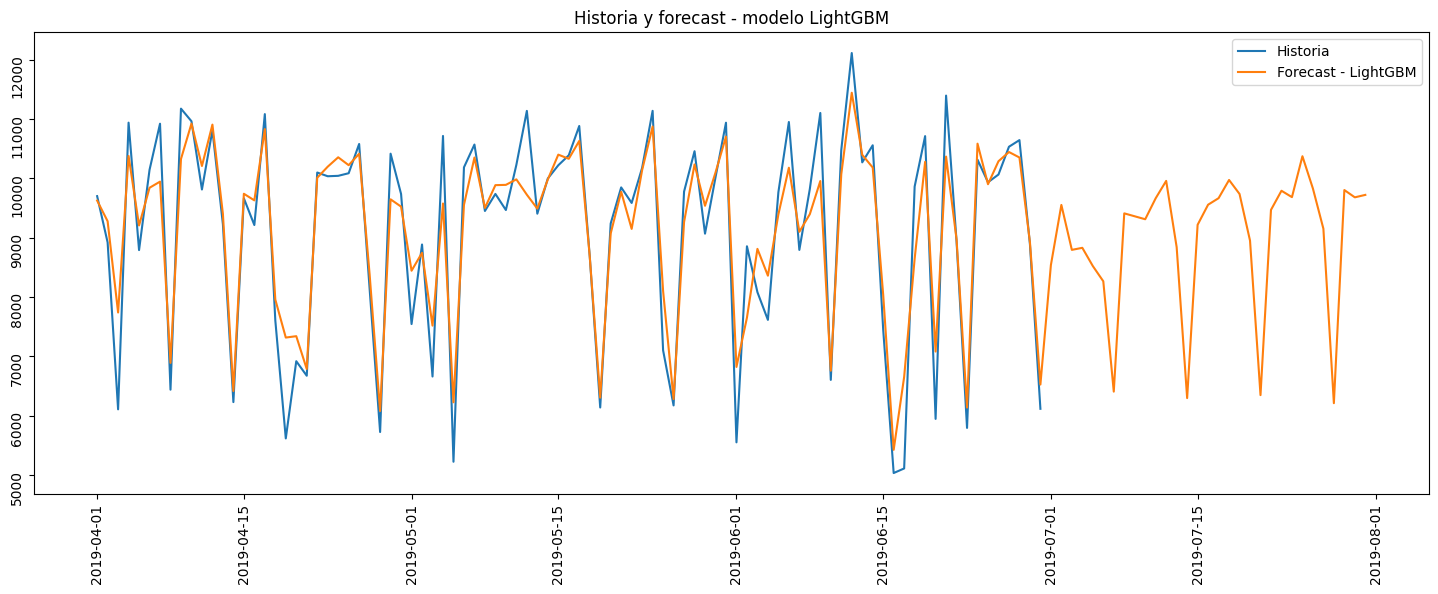

In [ ]:
plot_results(df, start_date='2019-04-01', end_date='2019-07-31', forecast_col=['LightGBM'], model_name='LightGBM')

### ARIMA

In [ ]:
df_arima_train = df_no_nan.set_index('fecha')
df_arima_test = df_nan.set_index('fecha')
endog = df_arima_train['cantidad_pasos']
exog_cols = ['tavg', 'prcp', 'month-August',
       'month-December', 'month-February', 'month-January', 'month-July',
       'month-June', 'month-March', 'month-May', 'month-November',
       'month-October', 'month-September', 'Weekday_Name-Monday',
       'Weekday_Name-Saturday', 'Weekday_Name-Sunday', 'Weekday_Name-Thursday',
       'Weekday_Name-Tuesday', 'Weekday_Name-Wednesday']
exog = df_arima_train[exog_cols]

ar = 7
mas = [1, 3, 7]

for ma in [1, 3, 7]:
    arima = ARIMA(endog, exog=exog, order=(ar, 0, ma))
    model = arima.fit()
    fit = list(model.predict())
    pred = list(model.predict(start='2019-07-01', end='2019-12-31', exog=df_nan[exog_cols]))
    full_pred = fit + pred
    df[f'ARIMA_{ar}_0_{ma}'] = full_pred

df[['fecha', 'cantidad_pasos', 'ARIMA_7_0_1', 'ARIMA_7_0_3', 'ARIMA_7_0_7']].head()

,fecha,cantidad_pasos,ARIMA_7_0_1,ARIMA_7_0_3,ARIMA_7_0_7
0,2016-01-01,5446.0,9536.195679,9534.141392,9536.239071
1,2016-01-02,6927.0,6971.370900,7113.205321,6996.938872
2,2016-01-03,6630.0,5740.239504,5880.245265,5728.454909
3,2016-01-04,9835.0,8568.825710,8573.764401,8470.429577
4,2016-01-05,9091.0,9352.734847,9333.649889,9314.292392


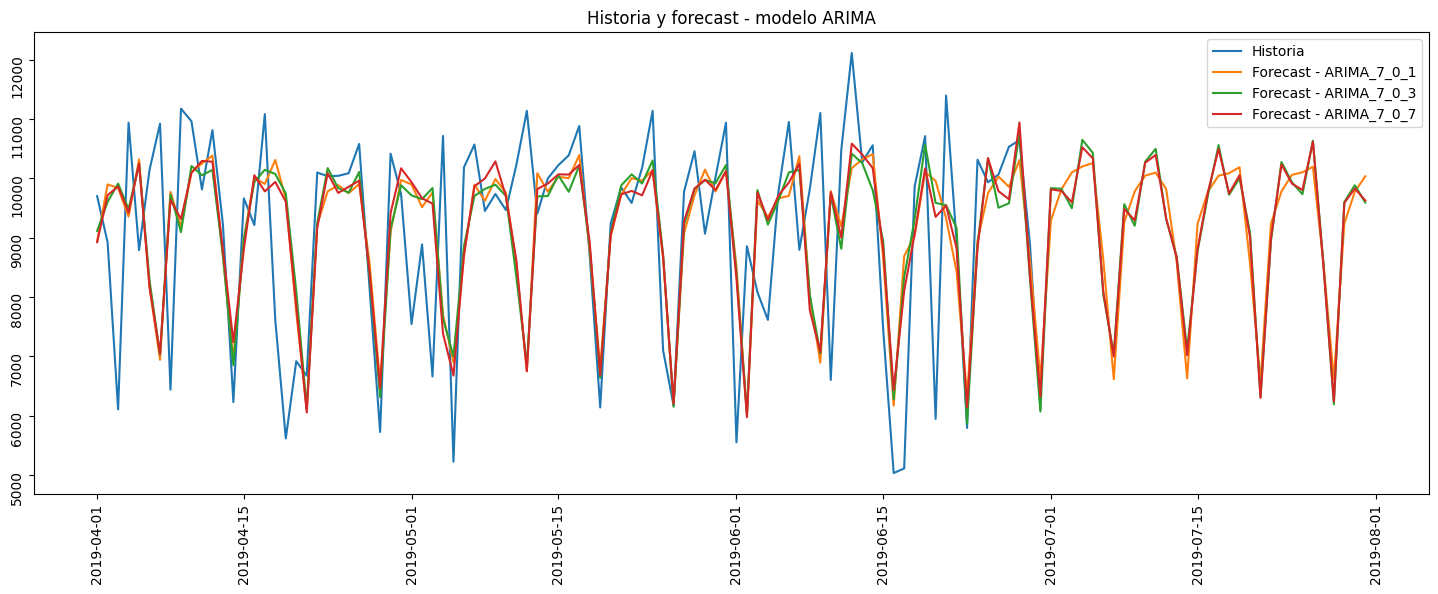

In [ ]:
plot_results(df, start_date='2019-04-01', end_date='2019-07-31', forecast_col=['ARIMA_7_0_1', 'ARIMA_7_0_3', 'ARIMA_7_0_7'], model_name='ARIMA')

### Prophet

In [ ]:
# Leemos archivo de feriados
url_feriados = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTINTbyXCZut4r4k72fRJtKsSG-nI9WlegF1eLtZqtp_SVIcdbzhe_pZb67JuKoOukBGl2x3ruojs6W/pub?gid=148040929&single=true&output=csv'
df_holidays = pd.read_csv(url_feriados)
df_holidays.head(10)

,holiday,ds,lower_window,upper_window
0,new_years,1/1/2016,0,1
1,carnaval,2/8/2016,0,1
2,carnaval,2/9/2016,0,1
3,dia_memoria,3/24/2016,0,1
4,semana_santa,3/25/2016,0,1
5,malvinas,4/2/2016,0,1
6,trabajador,5/1/2016,0,1
7,rev_mayo,5/25/2016,0,1
8,guemes,6/17/2016,0,1
9,belgrano,6/20/2016,0,1


In [ ]:
# Instanciamos modelo
model = Prophet(holidays = df_holidays,
                weekly_seasonality = True,
                daily_seasonality = True,
                yearly_seasonality = True)

# Sumamos los regresores externos

exog_cols = ['tavg', 'prcp']
for col in exog_cols:
    model.add_regressor(col)

# Fiteamos, las columnas deben tener orden especifico
df_prophet_train = df_no_nan.copy()
df_prophet_train = df_prophet_train[['fecha', 'tavg', 'prcp', 'cantidad_pasos']].rename(columns={
    'fecha': 'ds', 'cantidad_pasos': 'y'
})
model.fit(df_prophet_train)

# Creamos df de predicciones
future_df = model.make_future_dataframe(
        periods=len(df_nan), freq='D', include_history=True
    )
df['ds'] = df['fecha'].copy()

# Mergeamos info externa
future_df = pd.merge(future_df, df[['ds', 'tavg', 'prcp']], how='left', on='ds')

# Hacemos prediccion
forecast_df = model.predict(future_df)
pred = list(forecast_df['yhat'])
df['Prophet'] = pred


df[['fecha','cantidad_pasos','Prophet']].head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpmi5ylbwi/67vopn5z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmi5ylbwi/kig1qxsx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6949', 'data', 'file=/tmp/tmpmi5ylbwi/67vopn5z.json', 'init=/tmp/tmpmi5ylbwi/kig1qxsx.json', 'output', 'file=/tmp/tmpmi5ylbwi/prophet_modelplhlfwgu/prophet_model-20230912180642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,fecha,cantidad_pasos,Prophet
0,2016-01-01,5446.0,7143.536266
1,2016-01-02,6927.0,7831.573094
2,2016-01-03,6630.0,5882.713749
3,2016-01-04,9835.0,8623.787193
4,2016-01-05,9091.0,8823.777724


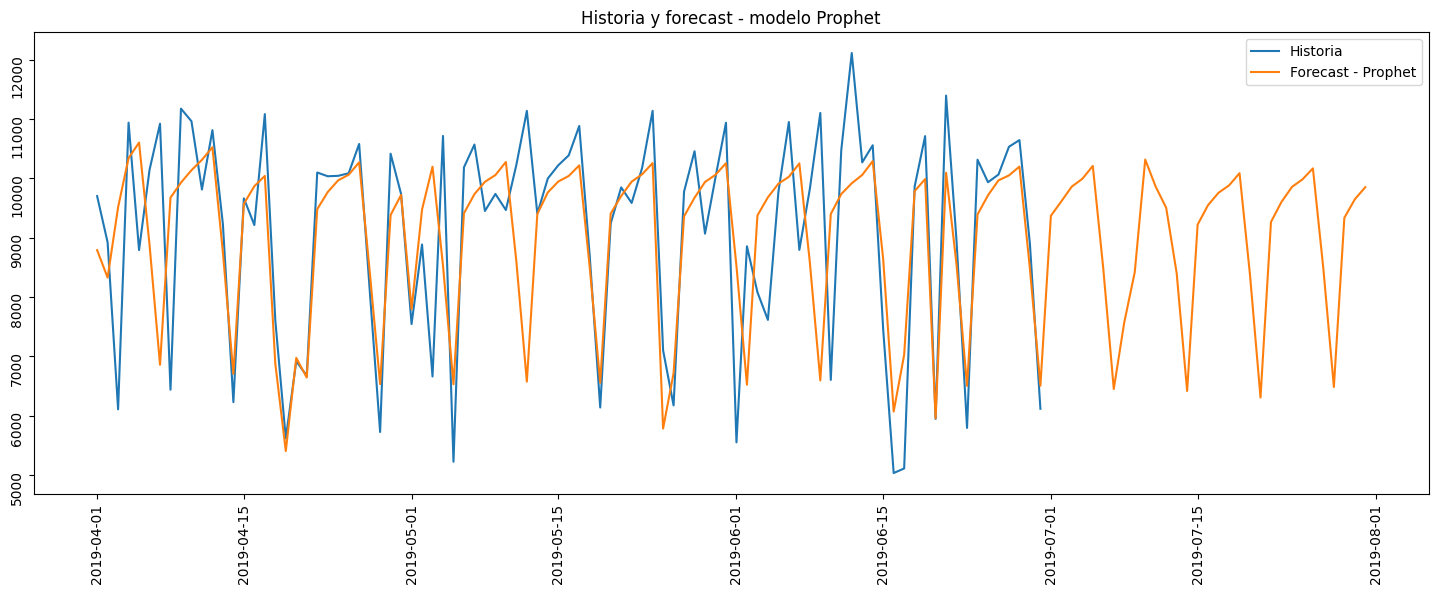

In [ ]:
plot_results(df, start_date='2019-04-01', end_date='2019-07-31', forecast_col=['Prophet'], model_name='Prophet')

## Medición

In [ ]:
models = [
    'Naive Last Value Forecast',
    'Naive Last Cycle Forecast',
    'Expo_0.2_pred',
    'Expo_0.5_pred',
    'Expo_0.8_pred',
    'Holt_0.5_0.2_pred',
    'Holt_0.5_0.5_pred',
    'Expo_0.5_0.1_0.2_pred',
    'Expo_0.5_0.1_0.5_pred',
    'Expo_0.5_0.1_0.8_pred',
    'Expo_Opti',
    'OLS',
    'LightGBM',
    'ARIMA_7_0_1',
    'ARIMA_7_0_3',
    'ARIMA_7_0_7',
    'Prophet',
    'AVG_3',
    'AVG_7'
]

In [ ]:
# Comenzamos haciendo una medicion sobre los datos de training
df_no_nan = df[df['fecha'] < '2019-07-01']
df_nan = df[df['fecha'] >= '2019-07-01']

model_list = []
wapes = []
biases = []

for model in models:
    # Para cada modelo, calculamos WAPE y Bias
    df_no_nan['ABS_ERROR'] = abs(df_no_nan[model] - df_no_nan['cantidad_pasos'])
    df_no_nan['ERROR'] = df_no_nan[model] - df_no_nan['cantidad_pasos']

    wape = np.sum(df_no_nan['ABS_ERROR'])/np.sum(df_no_nan['cantidad_pasos'])
    bias = round(np.sum(df_no_nan['ERROR'])/np.sum(df_no_nan['cantidad_pasos']), 2)

    model_list.append(model)
    wapes.append(wape)
    biases.append(bias)

df_metrics_train = pd.DataFrame(data={
    'Model': model_list,
    'WAPE_Train': wapes,
    'Bias_Train': biases
}).sort_values(by='WAPE_Train').reset_index(drop=True)
df_metrics_train['Ranking_Train'] = df_metrics_train.index + 1
df_metrics_train

,Model,WAPE_Train,Bias_Train,Ranking_Train
0,LightGBM,0.032894,-0.00,1
1,Prophet,0.057223,-0.00,2
2,Expo_Opti,0.065726,0.00,3
3,ARIMA_7_0_1,0.071758,-0.00,4
4,ARIMA_7_0_3,0.072094,-0.00,5
5,ARIMA_7_0_7,0.072302,-0.00,6
6,Naive Last Cycle Forecast,0.072743,-0.01,7
7,OLS,0.076652,-0.00,8
8,Expo_0.5_0.1_0.2_pred,0.082294,-0.00,9
9,Expo_0.5_0.1_0.5_pred,0.091647,-0.00,10


Veamos cómo es la performance en un set de datos nuevos

In [ ]:
url_test_data = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTVVh6ekUEGHtxC-YrA1VHu4QZDUa6Lj30HSPOgK2pTFqjupac8NeyBIEg4JfJ19_iysGlmeFkJNKNC/pub?gid=1614609268&single=true&output=csv'
df_test = pd.read_csv(url_test_data)
df_test['fecha'] = pd.to_datetime(df_test['fecha'], format = '%d/%m/%Y')
df_test.head()

,estacion,fecha,cantidad_pasos
0,alberdi,2019-07-01,8996
1,alberdi,2019-07-02,8963
2,alberdi,2019-07-03,10328
3,alberdi,2019-07-04,6485
4,alberdi,2019-07-05,10659


In [ ]:
df_nan.head()

,estacion,fecha,cantidad_pasos,Year-Month,Weekday,Weekday_Name,lag_1,diff_1,avg_by_weekday,cantidad_pasos_deseas,...,lag_2,lag_3,lag_7,OLS,LightGBM,ARIMA_7_0_1,ARIMA_7_0_3,ARIMA_7_0_7,ds,Prophet
1277,alberdi,2019-07-01,NaN,2019-07,0,Monday,6117.0,NaN,9240.131868,NaN,...,8892.0,10644.0,10314.0,9341.641912,8538.345102,9288.872487,9835.510538,9813.828586,2019-07-01,9368.754838
1278,alberdi,2019-07-02,NaN,2019-07,1,Tuesday,NaN,NaN,9777.725275,NaN,...,6117.0,8892.0,9934.0,9906.359071,9551.952653,9814.576717,9823.791990,9787.728681,2019-07-02,9613.359846
1279,alberdi,2019-07-03,NaN,2019-07,2,Wednesday,NaN,NaN,10049.565930,NaN,...,NaN,6117.0,10064.0,10054.342131,8794.693652,10099.908169,9495.478969,9596.572574,2019-07-03,9861.737699
1280,alberdi,2019-07-04,NaN,2019-07,3,Thursday,NaN,NaN,10100.148350,NaN,...,NaN,NaN,10532.0,10097.443238,8829.201774,10200.342830,10648.558882,10523.498899,2019-07-04,9991.270538
1281,alberdi,2019-07-05,NaN,2019-07,4,Friday,NaN,NaN,10208.830600,NaN,...,NaN,NaN,10644.0,10013.371565,8522.515934,10257.022049,10429.067459,10336.086506,2019-07-05,10208.713680


In [ ]:
df_test = pd.merge(df_test, df_nan[['fecha']+models], how='left', on='fecha')
df_test.head()

,estacion,fecha,cantidad_pasos,Naive Last Value Forecast,Naive Last Cycle Forecast,Expo_0.2_pred,Expo_0.5_pred,Expo_0.8_pred,Holt_0.5_0.2_pred,Holt_0.5_0.5_pred,...,Expo_0.5_0.1_0.8_pred,Expo_Opti,OLS,LightGBM,ARIMA_7_0_1,ARIMA_7_0_3,ARIMA_7_0_7,Prophet,AVG_3,AVG_7
0,alberdi,2019-07-01,8996,6117.0,9788.0,8835.679302,7879.230346,6740.368913,7738.727380,6876.320161,...,10783.377704,9346.443851,9341.641912,8538.345102,9288.872487,9835.510538,9813.828586,9368.754838,8551.0,9499.571429
1,alberdi,2019-07-02,8963,6117.0,10433.0,8835.679302,7879.230346,6740.368913,7433.811008,5766.385195,...,11050.060469,10165.963601,9906.359071,9551.952653,9814.576717,9823.791990,9787.728681,9613.359846,7504.5,9363.833333
2,alberdi,2019-07-03,10328,6117.0,10250.0,8835.679302,7879.230346,6740.368913,7128.894636,4656.450229,...,10804.151327,10188.403951,10054.342131,8794.693652,10099.908169,9495.478969,9596.572574,9861.737699,6117.0,9249.800000
3,alberdi,2019-07-04,6485,6117.0,10687.0,8835.679302,7879.230346,6740.368913,6823.978263,3546.515263,...,11080.529766,10105.875003,10097.443238,8829.201774,10200.342830,10648.558882,10523.498899,9991.270538,6117.0,9046.250000
4,alberdi,2019-07-05,10659,6117.0,11338.0,8835.679302,7879.230346,6740.368913,6519.061891,2436.580296,...,11329.773116,8462.273612,10013.371565,8522.515934,10257.022049,10429.067459,10336.086506,10208.713680,6117.0,8551.000000


In [ ]:
model_list = []
wapes = []
biases = []

for model in models:
    # Para cada modelo, calculamos WAPE y Bias
    df_test['ABS_ERROR'] = abs(df_test[model] - df_test['cantidad_pasos'])
    df_test['ERROR'] = df_test[model] - df_test['cantidad_pasos']

    wape = np.sum(df_test['ABS_ERROR'])/np.sum(df_test['cantidad_pasos'])
    bias = round(np.sum(df_test['ERROR'])/np.sum(df_test['cantidad_pasos']), 2)

    model_list.append(model)
    wapes.append(wape)
    biases.append(bias)

df_metrics_test = pd.DataFrame(data={
    'Model': model_list,
    'WAPE_Test': wapes,
    'Bias_Test': biases
}).sort_values(by='WAPE_Test').reset_index(drop=True)
df_metrics_test['Ranking_Test'] = df_metrics_test.index + 1
df_metrics_test

,Model,WAPE_Test,Bias_Test,Ranking_Test
0,Prophet,0.107819,-0.02,1
1,ARIMA_7_0_7,0.109603,0.01,2
2,Expo_Opti,0.110235,0.01,3
3,ARIMA_7_0_3,0.110303,0.01,4
4,ARIMA_7_0_1,0.110866,0.01,5
5,OLS,0.114962,-0.01,6
6,Naive Last Cycle Forecast,0.121217,0.01,7
7,LightGBM,0.124598,-0.04,8
8,Expo_0.2_pred,0.164875,-0.06,9
9,Expo_0.5_0.1_0.2_pred,0.172174,0.14,10


In [ ]:
df_metrics = pd.merge(df_metrics_train, df_metrics_test, how='left', on='Model').sort_values(by='WAPE_Test').reset_index(drop=True)
df_metrics

,Model,WAPE_Train,Bias_Train,Ranking_Train,WAPE_Test,Bias_Test,Ranking_Test
0,Prophet,0.057223,-0.00,2,0.107819,-0.02,1
1,ARIMA_7_0_7,0.072302,-0.00,6,0.109603,0.01,2
2,Expo_Opti,0.065726,0.00,3,0.110235,0.01,3
3,ARIMA_7_0_3,0.072094,-0.00,5,0.110303,0.01,4
4,ARIMA_7_0_1,0.071758,-0.00,4,0.110866,0.01,5
5,OLS,0.076652,-0.00,8,0.114962,-0.01,6
6,Naive Last Cycle Forecast,0.072743,-0.01,7,0.121217,0.01,7
7,LightGBM,0.032894,-0.00,1,0.124598,-0.04,8
8,Expo_0.2_pred,0.149816,-0.00,13,0.164875,-0.06,9
9,Expo_0.5_0.1_0.2_pred,0.082294,-0.00,9,0.172174,0.14,10
